In [22]:
import numpy as np
import pandas as pd

import statsmodels
from statsmodels.tsa.stattools import coint
# just set the seed for the random number generator
np.random.seed(107)

import matplotlib.pyplot as plt

In [23]:
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime

startDateStr = '2020/02/29'
endDateStr = '2020/07/29'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['TAIT', 'WSTG']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']

Processing data for stock: TAIT
Processing data for stock: WSTG
20% done...
40% done...
60% done...
80% done...


In [24]:
data.head(3)

,TAIT,WSTG
2020-03-02,2.47486,15.753098
2020-03-03,2.45514,16.030512
2020-03-04,2.42556,16.456539


3.3564846835185525e-05


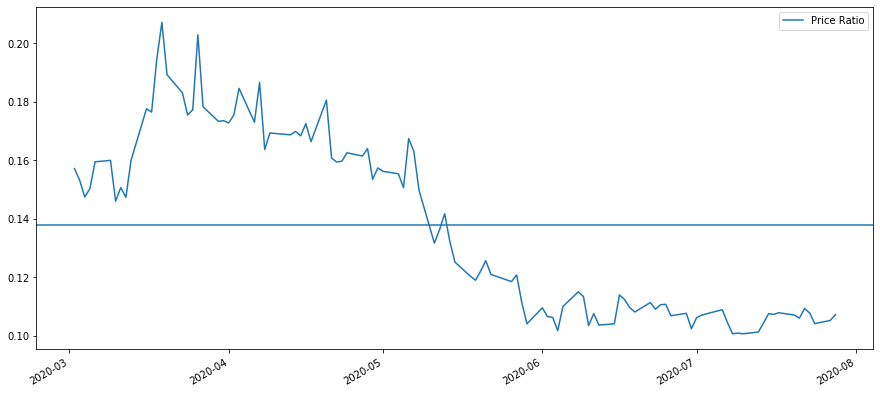

In [26]:
S1 = data['TAIT']
S2 = data['WSTG']
score, pvalue, _ = coint(S1, S2)
print(pvalue)
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()


In [27]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

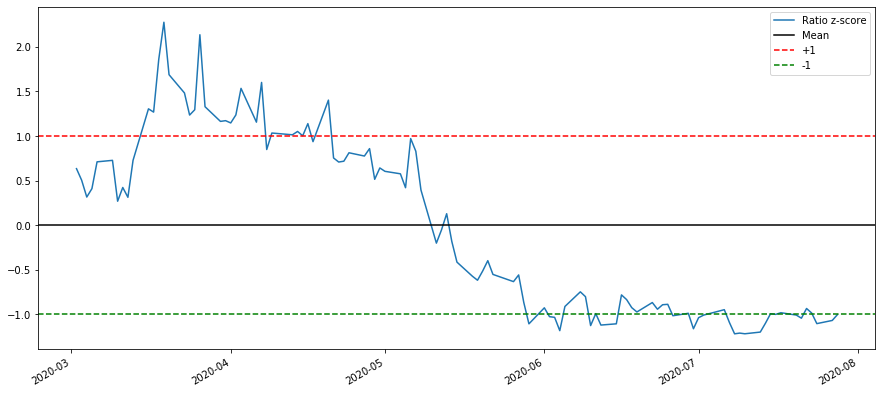

In [84]:
zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

In [31]:
ratios = data['TAIT'] / data['WSTG']
print(len(ratios))
train = ratios[:73]
test = ratios[73:]

104


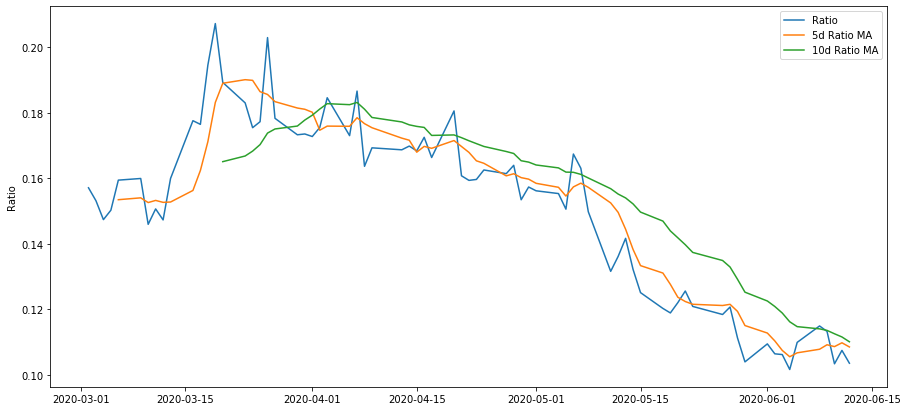

In [62]:
ratios_mavg1 = train.rolling(window=1,
                               center=False).mean()

ratios_mavg5 = train.rolling(window=5,
                               center=False).mean()

std_15 = train.rolling(window=15,
                        center=False).std()

zscore_15_5 = (ratios_mavg5 - ratios_mavg15)/std_15
plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg15.index, ratios_mavg15.values)

plt.legend(['Ratio','5d Ratio MA', '10d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

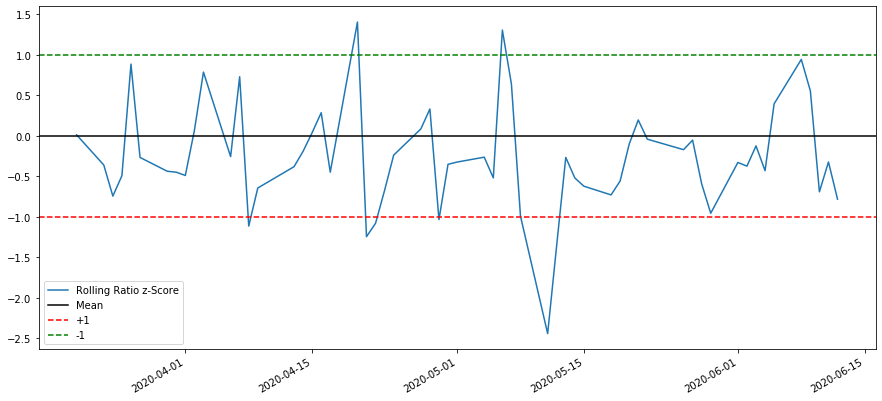

In [85]:

# Take a rolling 60 day standard deviation
std_15 = train.rolling(window=15,center=False).std()
std_10.name = 'std 10d'

# Compute the z score for each day
zscore_15_5 = (ratios_mavg1 - ratios_mavg5)/std_15
zscore_15_5.name = 'z-score'

plt.figure(figsize=(15,7))
zscore_15_5.plot()
plt.axhline(0, color='black')
plt.axhline(-1, color='red', linestyle='--')
plt.axhline(1, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

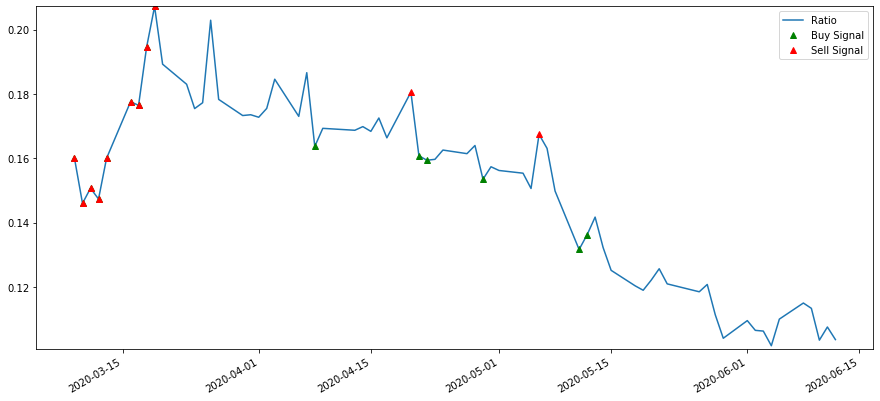

In [86]:

# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))

train[5:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_15_5>-1] = 0
sell[zscore_15_5<1] = 0
buy[5:].plot(color='g', linestyle='None', marker='^')
sell[5:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

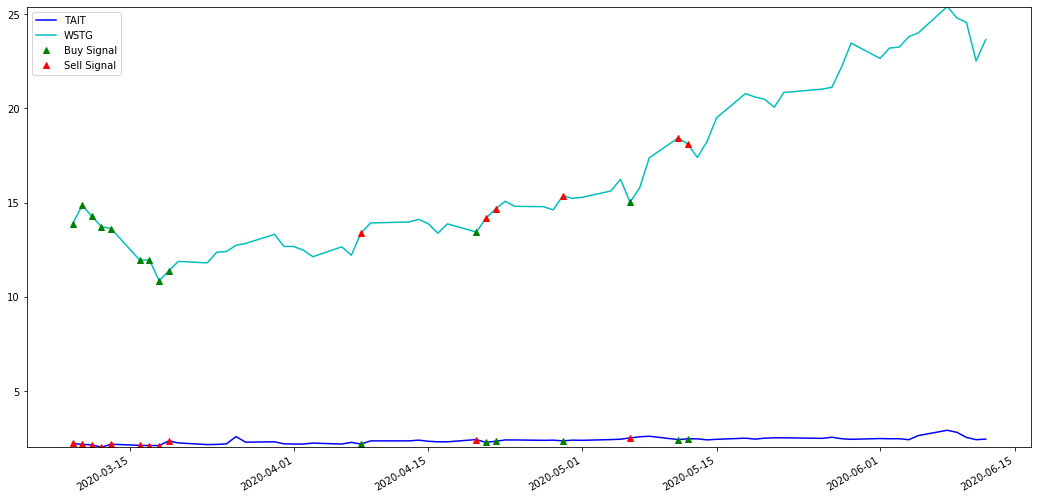

In [87]:
# Plot the prices and buy and sell signals from z score
plt.figure(figsize=(18,9))
S1 = data['TAIT'].iloc[:73]
S2 = data['WSTG'].iloc[:73]

S1[5:].plot(color='b')
S2[5:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[5:].plot(color='g', linestyle='None', marker='^')
sellR[5:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

plt.legend(['TAIT','WSTG', 'Buy Signal', 'Sell Signal'])
plt.show()

In [91]:
def trade(S1, S2, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < -1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -0.25 and .25
        elif abs(zscore[i]) < 0.75:
            money += countS1*S1[i] + S2[i] * countS2
            countS1 = 0
            countS2 = 0
#         print('Z-score: '+ str(zscore[i]), countS1, countS2, S1[i] , S2[i])
    return money


trade(data['TAIT'].iloc[:73], data['WSTG'].iloc[:73], 1, 5)

2.2952911361127986

In [94]:
trade(data['TAIT'].iloc[73:], data['WSTG'].iloc[73:], 1, 5)

0.12554752672877867

In [72]:
# Profit Analysis

In [116]:
# Find the window length 0-254 
# that gives the highest returns using this strategy
length_scores = [trade(data['TAIT'].iloc[:73], 
                data['WSTG'].iloc[:73], 1, l) 
                for l in range(50)]
best_length = np.argmax(length_scores)
print ('Best window length:', best_length)

Best window length: 6


In [117]:
# Find the returns for test data
# using what we think is the best window length
length_scores_test = [trade(data['TAIT'].iloc[73:], 
                  data['WSTG'].iloc[73:],1, l) 
                  for l in range(50)]
print (best_length, 'test day window:', length_scores_test[best_length])
length_scores_train = [trade(data['TAIT'].iloc[:73], 
                  data['WSTG'].iloc[:73],1, l) 
                  for l in range(50)]
print (best_length, 'train day window:', length_scores_train[best_length])

# Find the best window length based on this dataset, 
# and the returns using this window length
best_length2 = np.argmax(length_scores2)
print (best_length2, 'day window:', length_scores2[best_length2])

6 test day window: 0.21933023704094534
6 train day window: 2.3945279746882946
6 day window: 2.3945279746882946


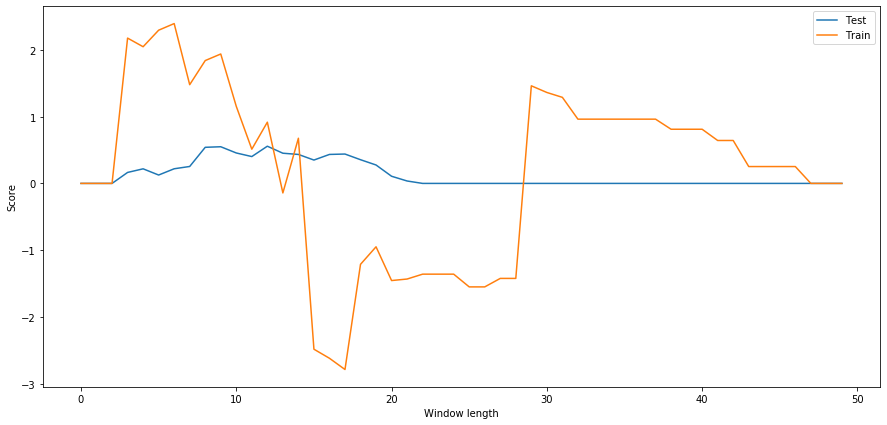

In [119]:
plt.figure(figsize=(15,7))
plt.plot(length_scores_test)
plt.plot(length_scores_train)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['Test', 'Train'])
plt.show()